In [1]:
import os
import sys 
import glob
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance, era5_wind_point

## - Load DCA files

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/DCA/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios

['Aghulas_20190510',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Aghulas_20190515']

In [4]:
scenario = 'Aghulas_20190515'
files_dca = glob.glob(f"{data_dir+scenario}/*.nc")
files_dca = [file for file in files_dca if 'S1B' in file]
files_dca

['/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172402-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172427-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172337-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172452-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc',
 '/Users/opodriscoll/Documents/Data/Sentinel1/DCA/Aghulas_20190515/20190515T172312-WOC-L2P-CUReul-S1B-OSC_RVL-v1.0-fv1.1.nc']

## - Load Sentinel-1 files

In [5]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [6]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

observation = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [8]:
observation.apply()

Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Aghulas_20190515/380C_A15C_E78E_EF27_FA2B_res200.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20190515h1700_lat-37_38_lon20_92.nc


In [9]:
obj_copy = copy.deepcopy(observation)

## - Interpolate and add DCA to Sentinel-1

In [66]:
ts = []
longitudes = []
latitudes = []
dcas = []
lafs = []
for i, file in enumerate(files_dca):
    data = xr.open_dataset(file)
    longitudes.append(data.lon.values.ravel())
    latitudes.append(data.lat.values.ravel())
    dca = data.doppler_centroid_anomaly.values.ravel()
    laf = data.land_area_fraction.values.ravel()
    dcas.append(dca); lafs.append(laf)

In [96]:
data#.signal_to_noise.isel(swath = 0).plot(robust=True)

<xarray.Dataset>
Dimensions:                          (row: 233, cell: 127, swath: 3, time: 1)
Coordinates:
    lat                              (row, cell, swath) float32 -41.86 ... 9....
    lon                              (row, cell, swath) float32 21.04 ... 9.9...
  * time                             (time) datetime64[ns] 2019-05-15T17:23:2...
Dimensions without coordinates: row, cell, swath
Data variables: (12/13)
    doppler_centroid_anomaly         (row, cell, swath) float32 nan nan ... nan
    doppler_centroid_std             (row, cell, swath) float32 ...
    sigma0                           (row, cell, swath) float32 ...
    quality_level                    (row, cell, swath) int8 ...
    land_area_fraction               (row, cell, swath) float32 0.0 0.0 ... nan
    radial_direction                 (row, cell, swath) float32 ...
    ...                               ...
    incidence_angle                  (row, cell, swath) float32 ...
    eastward_stokes_drift_velocity   (row, cell, swath) float32 ...
    northward_stokes_drift_velocity  (row, cell, swath) float32 ...
    wind_speed                       (row, cell, swath) float32 ...
    wind_direction                   (row, cell, swath) float32 ...
    wave_bias                        (row, cell, swath) float32 ...
Attributes: (12/59)
    Conventions:                   CF-1.7, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Climate and Forecast (CF) 1.7, Attribute C...
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         Sentinel-1 IW Ocean Surface Current Radial...
    summary:                       This dataset contains calibrated Sentinel-...
    id:                            WOC-L2P-CUReul-S1B-OSC_RVL
    ...                            ...
    key_variables:                 doppler_centroid_anomaly
    date_created:                  2022-03-23T09:42:54.546382
    date_modified:                 2022-03-23T09:42:54.546389
    source:                        S1-OSC-RVL
    source_version:                1.0
    input:                         S1B_IW_SL2__1_SV_20190515T172312_20190515T...

In [67]:
np.concatenate(dcas, axis = 0)
df = pd.DataFrame(
    data = {'lon': np.concatenate(longitudes, axis = 0),
            'lat': np.concatenate(latitudes, axis = 0),
            'dca': np.concatenate(dcas, axis = 0),
            'laf': np.concatenate(lafs, axis = 0)})
df.where(abs(df) < 1e10, np.nan, inplace=True)
df.dropna(inplace=True)

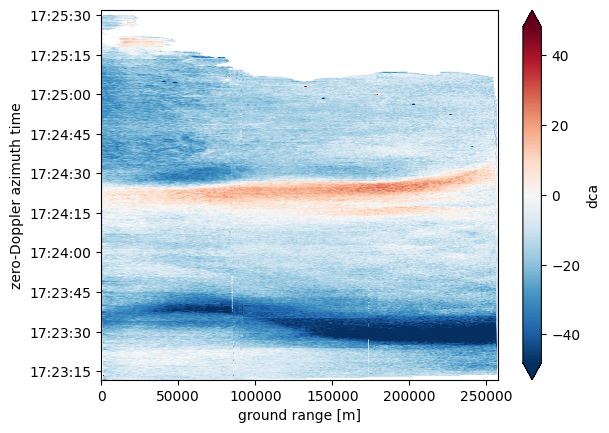

In [68]:
interp_dca = LinearNDInterpolator(list(zip(df.lon.values, df.lat.values)), df.dca.values)
interp_laf = LinearNDInterpolator(list(zip(df.lon.values, df.lat.values)), df.laf.values)

dca_interp = interp_dca(obj_copy.S1_file.longitude.values, obj_copy.S1_file.latitude.values)
laf_interp = interp_laf(obj_copy.S1_file.longitude.values, obj_copy.S1_file.latitude.values)
dca_interp = np.where(laf_interp > 0, np.nan, dca_interp)
obj_copy.S1_file['dca'] = (['azimuth_time', 'ground_range'], dca_interp)

obj_copy.S1_file.dca.plot(robust = True)

In [168]:
obj_copy.create_dataset()
obj_copy.data['dca_s1'] = (['az', 'grg'], obj_copy.S1_file['dca'].data)
obj_copy.create_beam_mask()

The Sentinel-1 DCA data is provided in radial velocity w.r.t. the sensor: DCA_radial. Therefore, it must first be corrected to the radial velocity in the scatterometer's line of sight: DCA_scatt.

<p align="center">
    <img src="images/sketch_S1_rvl_to_scatt_rvl.png" alt="Example Image">
</p>

DCA_scatt is calculated as 
\begin{equation}
    \mathrm{DCA}_{\mathrm{scatt}} = \frac{\mathrm{DCA}_{\mathrm{radial}} \cos\left(a\right)}{\cos\left(b\right)}
\end{equation}

where $a$ is the elevation angle of the scatterometer and $b$ that of Sentinel-1 with 
 
 \begin{equation}
    \theta_{\mathrm{elevation}} = 90 - \theta_{\mathrm{incidence}}
 \end{equation}

In [169]:
numerator = obj_copy.data['dca_s1'] * np.cos(np.deg2rad(90 - observation.data['inc']))
denominator = np.cos(np.deg2rad(90 - observation.data['inc_scatt_eqv']))
obj_copy.data['dca_scatt'] = numerator / denominator

In [170]:
# compute weighted received Doppler and resulting apparent LOS velocity
observation.data['dop_beam_weighted_w_dca'] = (obj_copy.data.dca_scatt + observation.data['dop_geom']) * observation.data['beam']* observation.data['nrcs_weight']
observation.data['dca_beam_weighted'] = obj_copy.data.dca_scatt * observation.data['beam'] * observation.data['nrcs_weight']

# sum over azimuth to receive range-slow_time results
weight_rg = (observation.data['beam'] * observation.data['nrcs_weight']).sum(dim='az_idx', skipna=False)
receive_rg = observation.data['dop_beam_weighted_w_dca'].sum(dim='az_idx', skipna=False)
observation.data[['dca_pulse_rg']] = observation.data['dca_beam_weighted'].sum(dim='az_idx', skipna=False) / weight_rg
observation.data[['doppler_w_dca_pulse_rg']] = receive_rg / weight_rg

observation.data['doppler_w_dca_pulse_rg_subscene'] = observation.data['doppler_w_dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()
observation.data['dca_pulse_rg_subscene'] = observation.data['dca_pulse_rg'].rolling(grg=observation.grg_N, slow_time=observation.slow_time_N, center=True).mean()

observation.data = observation.data.transpose('az_idx', 'grg', 'slow_time')

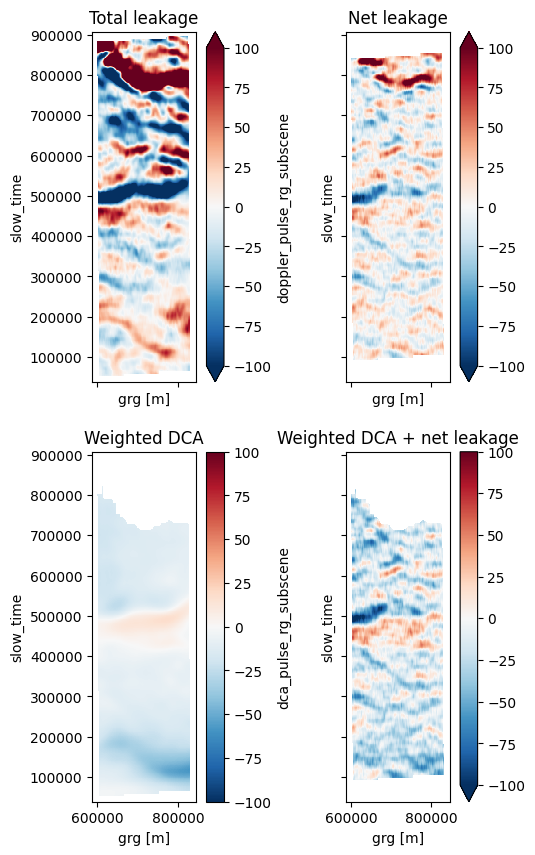

In [171]:
net_leakage_velocity = observation.data['doppler_pulse_rg_subscene']- observation.data['doppler_pulse_rg_subscene_inverted']

fig, axes = plt.subplots(2, 2, figsize=(6, 10), sharex=True, sharey=True)

observation.data['doppler_pulse_rg_subscene'].T.plot(vmax = 100, ax = axes[0,0])
net_leakage_velocity.T.plot(vmax = 100, ax = axes[0,1])
observation.data['dca_pulse_rg_subscene'].T.plot(vmax = 100, ax = axes[1,0])
(observation.data['dca_pulse_rg_subscene'] + net_leakage_velocity).T.plot(vmax = 100, ax = axes[1,1])

axes[0,0].set_title('Total leakage')
axes[0,1].set_title('Net leakage')
axes[1,0].set_title('Weighted DCA')
axes[1,1].set_title('Weighted DCA + net leakage')

_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]